# Traffic Volume in each Neighborhood
### Analyzed by Yu Wang

Dataset: [City of Pittsburgh Traffic Count](https://data.wprdc.org/dataset/traffic-count-data-city-of-pittsburgh)

**First, we load the shapefile containing the neighborhood data for Pittsburgh.**

In [5]:
import geopandas as gpd
import pandas as pd

# Load the shapefile using geopandas
neighborhoods = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')

neighborhoods.head(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."


**Load in the City of Pittsburgh Traffic Count dataset...** 

In [6]:
import pandas as pd
traffic_data = pd.read_csv('data/traffic-count.csv')
traffic_data.head(3)

# Show the first three items as a preview

,id,device_id,record_oid,count_start_date,count_end_date,average_daily_car_traffic,average_daily_bike_traffic,counter_number,counter_type,speed_limit,...,longitude,latitude,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone
0,1011743669,85,1.445865e+09,2019-04-18,2019-04-26,4949.0,NaN,6,StatTrak,25.0,...,-79.967772,40.455733,Polish Hill,7.0,6.0,42003060500,6.0,6.0,2.0,2-6
1,1026101993,140,1.121444e+09,2019-01-24,NaN,NaN,NaN,NaN,Intersection Study,NaN,...,-79.952249,40.466157,Central Lawrenceville,7.0,9.0,42003090200,2.0,9.0,2.0,3-6
2,1032382575,11,1.539893e+09,2018-08-28,2018-09-04,NaN,NaN,NaN,NaN,35.0,...,-80.076469,40.460717,Windgap,2.0,28.0,42003563000,5.0,28.0,6.0,1-16


There are three columns we should pick out and use: neighborhood, average_daily_car_traffic, and geographical location(longtitude and latitude).

For this metric and overall data analysis, we only count the car traffic(excludes the bike traffic), then determine if the traffic condition is good enough to walk in.
We collect the total traffic count for each neighborhood in the time period given by the dataset, and get the average traffic count by neighborhood.

The data is sorted in an ascending order, and the first 3 items are shown: 3 neighborhoods with fewest average traffic counts.

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the traffic-count dataset and neighborhoods shapefile
traffic_data = pd.read_csv('data/traffic-count.csv')
neighborhoods = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')
traffic_data = traffic_data[['neighborhood', 'average_daily_car_traffic', 'longitude', 'latitude']].dropna()
traffic_data['geometry'] = traffic_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
traffic_data = gpd.GeoDataFrame(traffic_data, geometry='geometry', crs=neighborhoods.crs)

def find_neighborhood(point, neighborhoods):
    for index, row in neighborhoods.iterrows():
        if row['geometry'].contains(point):
            return row['hood']
    return None

traffic_data['neighborhood'] = traffic_data['geometry'].apply(lambda point: find_neighborhood(point, neighborhoods))
traffic_data.dropna(subset=['neighborhood'], inplace=True)

# Collect the traffic counts by neighborhood names and calculate the average value
average_traffic_by_neighborhood = traffic_data.groupby('neighborhood').agg({'average_daily_car_traffic': 'mean'})
average_traffic_by_neighborhood.reset_index(inplace=True)
average_traffic_by_neighborhood.columns = ['Neighborhood', 'Average Traffic Count']

# Combine the geometry of neighborhoods and traffic data
result = neighborhoods.merge(average_traffic_by_neighborhood, left_on='hood', right_on='Neighborhood')

# The column for the display
result = result[['Neighborhood', 'geometry', 'Average Traffic Count']]

# Show the manipulated dataset
result.head(3)

,Neighborhood,geometry,Average Traffic Count
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",4964.000000
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",3939.111111
2,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...",3823.000000


**_The last step for this data process: Sort the data in an ascending order to show neighborhoods with relatively few traffic counts_**

In [9]:
# Show sorted values - in an ascneding order
result_sorted = result.sort_values(by='Average Traffic Count', ascending=True)
result_sorted.head(10)

,Neighborhood,geometry,Average Traffic Count
62,South Side Flats,"POLYGON ((-79.97726 40.43272, -79.97725 40.432...",115.000000
9,Lincoln Place,"POLYGON ((-79.91042 40.37842, -79.91038 40.378...",126.000000
14,Lincoln-Lemington-Belmar,"MULTIPOLYGON (((-79.90496 40.48522, -79.90470 ...",195.000000
63,Fineview,"POLYGON ((-80.00198 40.46814, -80.00129 40.467...",419.000000
20,Allegheny West,"POLYGON ((-80.00895 40.44996, -80.00894 40.449...",477.000000
25,New Homestead,"POLYGON ((-79.91621 40.39849, -79.91621 40.398...",666.000000
28,Overbrook,"POLYGON ((-79.99633 40.39458, -79.99630 40.394...",777.000000
53,Summer Hill,"POLYGON ((-80.01078 40.49975, -80.01073 40.499...",937.000000
45,Upper Hill,"POLYGON ((-79.95848 40.44846, -79.95861 40.448...",953.333333
26,Central Northside,"POLYGON ((-80.00228 40.45868, -80.00228 40.458...",1189.000000


For the table above, we combine the data both in the neighborhood shapefile and traffic count in terms of location/geometry. 
It seems that the location(longtitude and latitude) can match the geometry. We tried, and it works!
We also remove the items fail to match the geometry.


In this way, we can use geopandas to load and visualize data.


Again, the average traffic count is derived from - **total traffic counts for a neighborhood in a time frame / days counted** - that's the average traffic count for a neighborhood.

From the table above, we can see that the neighborhood South Side Flats has the fewest traffic counts.

 #### Then, let's plot the top 30 neighborhoods with the fewer traffic counts compared to other ones.

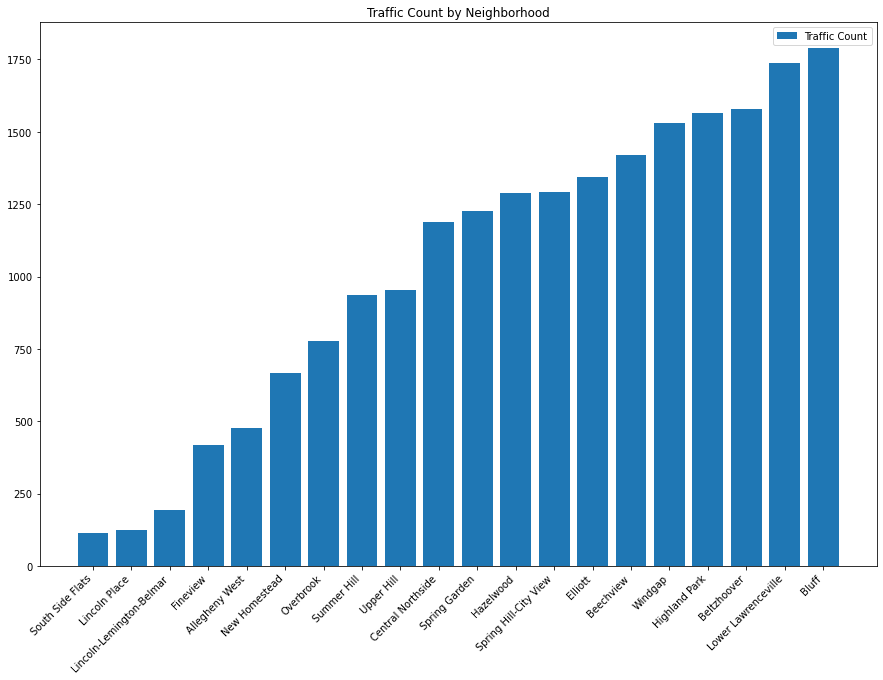

In [62]:
import matplotlib.pyplot as plt

top30 = result_sorted.head(20)

fig, axis = plt.subplots(figsize=(15,10))
bars = axis.bar(top30['Neighborhood'], top30['Average Traffic Count'])
axis.set_title("Traffic Count by Neighborhood")

axis.legend([bars[0]], ['Traffic Count'])
axis.set_xticklabels(top_20_neighborhoods['Neighborhood'], rotation=45, ha='right')
plt.show()


 #### Let's also plot the bottom 30 neighborhoods.

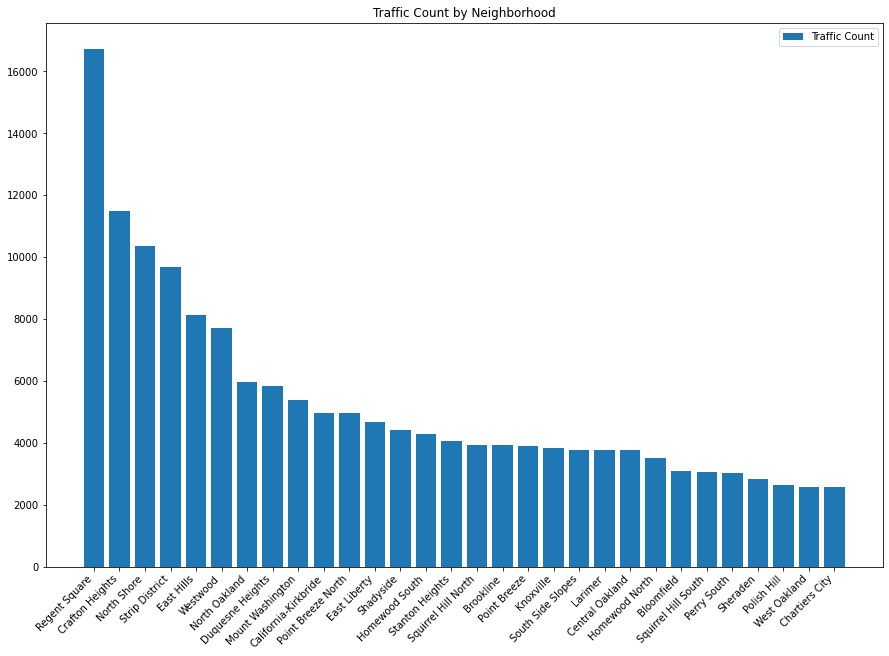

In [61]:
import matplotlib.pyplot as plt
descending_result = result_sorted.sort_values(by='Average Traffic Count', ascending=False)
bottom30 = descending_result.head(30)
fig, axis = plt.subplots(figsize=(15, 10))
bars = axis.bar(bottom30['Neighborhood'], bottom30['Average Traffic Count'])
axis.set_title("Traffic Count by Neighborhood")

axis.legend([bars[0]], ['Traffic Count'])
axis.set_xticklabels(bottom30['Neighborhood'], rotation=45, ha='right')
plt.show()


#### Since we merge the location data in traffic count dataset into the geometry in neighborhood shapefile, we can visualize the data as a colored map with the GeodataFrame.

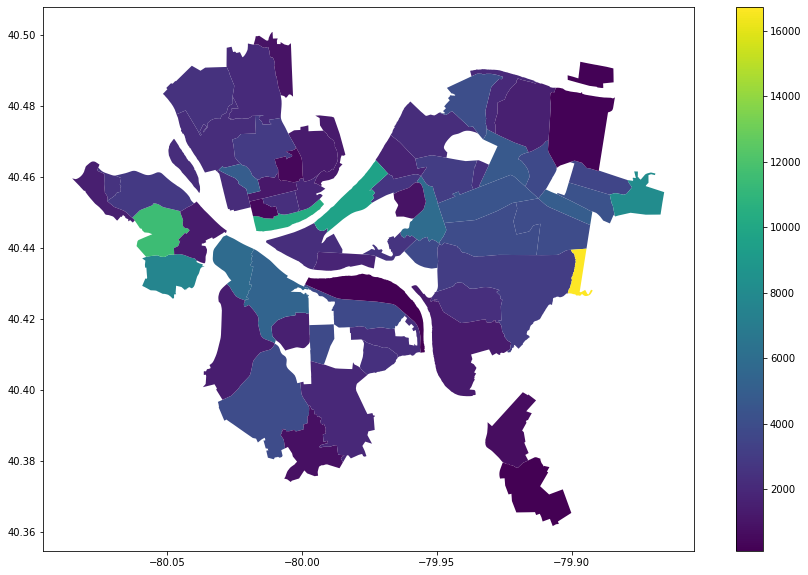

In [53]:
plt = result.plot(column="Average Traffic Count", legend=True, figsize=(15, 10))

## Conclusion

There are a few neighborhoods that have extremely high traffic counts in comparison to other neighborhoods. Overall, it appears that most Pittsburgh neighborhoods do not have high traffic volumes, and therefore many are suitable for walking.

Notably, Regent Square has the highest average traffic counts, while South Side Flats has the lowest average traffic counts.


#### According to this submetric (low traffic is good for walking - the lower the traffic the higher the score),
### South Side Flats earns the highest score!